In [1]:
using Pkg
Pkg.activate("../")

"/home/mo/git/FinNetValu/Project.toml"

In [2]:
using FinNetValu
using Distributions
using LinearAlgebra
using SparseArrays
using ForwardDiff
using Plots

# Demonstration of network valuations

## Examples from Suzuki (2002)

Here, we replicate some examples from the paper

Teruyoshi Suzuki, *Valuing corporate debt: the effect of cross-holdings of stock and debt*, Journal of the Operations Research, Vol. 45, 2002.

We start with fig. 6 showing the default spread of firms with cross-holdings.

Two firm networks corresponding to his examples A and B are defined as follows:

In [3]:
exampleA = XOSModel(spzeros(2,2), spzeros(2,2), I, [0.9, 0.9])
exampleB = XOSModel([0.0 0.2; 0.2 0.0], spzeros(2,2), I, [0.9, 0.9])

XOS model of N = 2 firms with equity cross holdings.

Next, we fix the parameters for the log-normal distributions of asset prices. Here, we only consider correlation $\rho = -0.9$ between the Brownian motions, but you may want to experiment with other settings as well.

In [4]:
r = 0.0
T = 10.0
σ = [0.2, 0.2]
Lᵨ = cholesky([1.0 -0.9; -0.9 1.0]).L;

The following functions compute the ex-ante value of firms debt and the resulting bond spread. To this end, we take the risk-neutral expectation of the discounted, self-consistent debt value at maturity. Note that we evaluate the expectation by transforming standard normal random variates $Z$ to asset prices $A_\tau$ which are then log-normally distributed. 

In [5]:
function debtval(net, τ)
    N = numfirms(net)
    θ = BlackScholesParams(r, τ, σ, Lᵨ)
    expectation(Z -> discount(θ) .* debtview(net, fixvalue(net, Aτ(ones(N), θ, Z))),
                MonteCarloSampler(MvNormal(N, 1.0)),
                25000)
end

function spread(net, τ)
    (log.(net.d) .- log.(debtval(net, τ))) ./ τ .- r
end

spread (generic function with 1 method)

For the figure, bond spreads are computed over a range of different maturities. As both firms are symmetric in the examples, we could either show the bond spread of a single firm or the mean of both firms (as done here).

In [6]:
maturities = range(0, length = 101, stop = T)
@time spreadsA = [spread(exampleA, τ)
                  for τ in maturities]
@time spreadsB = [spread(exampleB, τ)
                 for τ in maturities];

 35.581580 seconds (219.55 M allocations: 33.180 GiB, 14.16% gc time)
 32.153192 seconds (278.28 M allocations: 37.067 GiB, 16.96% gc time)


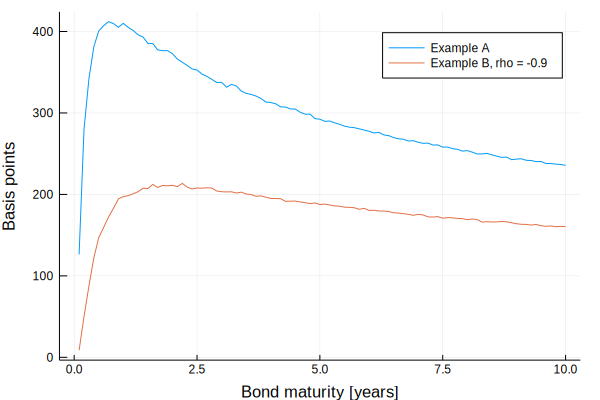

In [7]:
plt = plot(maturities, 10000 .* map(mean, spreadsA), label = "Example A",
           xlabel = "Bond maturity [years]", ylabel = "Basis points")
plot!(plt, maturities, 10000 .* map(mean, spreadsB), label = "Example B, rho = -0.9")

With similar ease we can replicate the firm values of the larger example.

In [ ]:
exampleN = XOSModel([0.0 0.2 0.3 0.1; 0.2 0.0 0.2 0.1; 0.1 0.1 0.0 0.3; 0.1 0.1 0.1 0.0],
                    [0.0 0.0 0.1 0.0; 0.0 0.0 0.0 0.1; 0.1 0.0 0.0 0.1; 0.0 0.1 0.0 0.0],
                    I,
                    [0.8, 0.8, 0.8, 0.8])

Aₜ = [2.0, 0.5, 0.6, 0.6]
X = zeros(8)
println("X_0 = ", X')
for i = 1:20
    X = valuation(exampleN, X, Aₜ)
    println("X_", i, " = ", X')
end

## Examples from Barucca et al. (2016)

Here we replicate some figures from the paper

Paolo Barucca, Marco Bardoscia, Fabio Caccioli, Marco D’Errico, Gabriele Visentin, Stefano Battiston and Guido Caldarelli, *Network Valuation in Financial Systems*, arXiv:1606.05164v2, 2016.

To reproduce figure 1, we use the simplest possible setup. I.e. we define the corresponding models with a single firm and run their valuations functions across a range of equities.

In [3]:
EN = EisenbergNoeModel([0.0], 2 .* ones(1,1))
Furfine = FurfineModel([0.0], 2 .* ones(1,1), 0)
LinearDR = LinearDebtRankModel([0.0], 2 * ones(1,1))

Linear Debt Rank model with N = 1 firms.

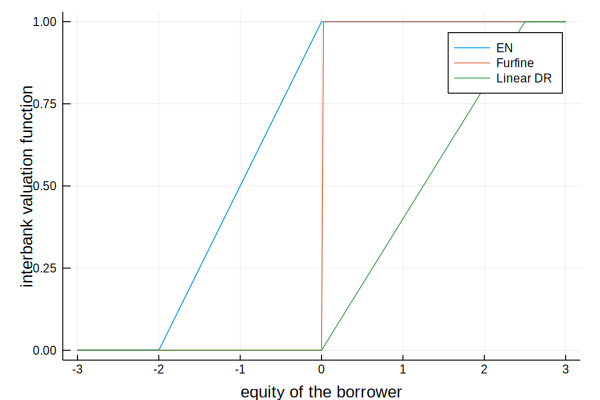

In [4]:
equities = range(-3, length = 251, stop = 3)
𝕍_EN = [EN.𝕍(EN, e, nothing)[1] for e in equities]
𝕍_Furfine = [Furfine.𝕍(Furfine, e, nothing)[1] for e in equities]
𝕍_LinearDR = [LinearDR.𝕍(LinearDR, e, [2.5])[1] for e in equities] # Note: A = 2.5 leads to book equity M = 2.5

plt = plot(equities, 𝕍_EN, label = "EN",
           xlabel = "equity of the borrower", ylabel = "interbank valuation function")
plot!(plt, equities, 𝕍_Furfine, label = "Furfine")
plot!(plt, equities, 𝕍_LinearDR, label = "Linear DR")

Note that the valuation formula $\mathbb{V}_{ij} = \frac{E_j^+}{M_j}$ for the linear debt rank model is actually not correct in the paper as it can exceed one. In practice, this should not be a problem as a firms equity value $E_j$ never exceeds its book equity $M_j$. Here, values are clipped between 0 and 1 as in the accompanying code at https://github.com/marcobardoscia/neva

Next, we replicate the left panel of figure 2.

Note: The ex-ante version of the Eisenberg & Noe model is not yet implemented.

In [5]:
# External liabilities
Lᵉ = [9., 4., 2.]
# Cross-holding matrix
A = [0 0.5 0;
     0 0 0.5;
     0.5 0 0]
# External asset values
Aᵉ = [10., 5., 3.]

models = [EisenbergNoeModel(Lᵉ, A'),
          FurfineModel(Lᵉ, A', 0.0),
          LinearDebtRankModel(Lᵉ, A')]

3-element Array{NEVAModel,1}:
 Eisenberg & Noe model with N = 3 firms. 
 Furfine model with N = 3 firms.         
 Linear Debt Rank model with N = 3 firms.

Each model is then shocked by decreasing the external asset value by a factor $\alpha$ and compute the impact on the equity value as in the paper, i.e.
$$
    \frac{\sum_i {\Delta}E_i - {\Delta}A^e_i}{\sum_{ij} A_{ij}}
$$
where ${\Delta}A^e = \alpha A^e$.

In [6]:
function runshock(model, Aᵉ, α)
    E₀ = fixvalue(model, Aᵉ)
    ΔAᵉ = α .* Aᵉ
    ΔE  = E₀ .- fixvalue(model, Aᵉ .- ΔAᵉ)
    sum(ΔE .- ΔAᵉ) / sum(model.A)
end

runshock (generic function with 1 method)

In [7]:
αs = range(0, length = 101, stop = 0.6)
shocks = collect(runshock(model, Aᵉ, α)
                 for α in αs,
                     model in models);

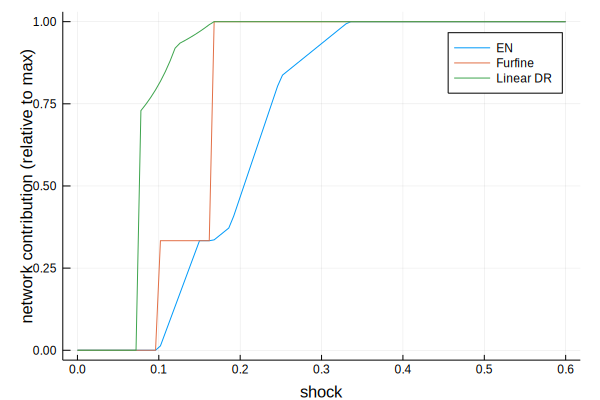

In [8]:
plot(αs, shocks, label = ["EN", "Furfine", "Linear DR"],
     xlabel = "shock", ylabel = "network contribution (relative to max)")

Again, the curve for the linear debt rank model looks different from the one in the paper. The reason might be that the valuation formula does not appear right when the book equity $M$ becomes negative!

TODO: Investigate that and fix formula.

## Examples from our paper

Here, we replicate some of the figures from the paper

Nils Bertschinger and Julian Stobbe, *Systemic Greeks: Measuring risk in financial networks*, arXiv:1810.11849, 2018.

### Single firm examples

We start with figure 1 and define a model with a single firm and self cross-holdings of strength $w^s$ and $w^d$ for equity and debt respectively.

In [ ]:
wˢ = 0.2
wᵈ = 0.4
singleFirm = XOSModel(wˢ .* ones(1,1), wᵈ .* ones(1,1), I, [1.0])

The self-consistent values at maturity across different external asset values are readily computed as the fixed point of the network valuation.

In [ ]:
extA = range(0, length = 51, stop = 1.5)
vals = [fixvalue(singleFirm, [a]) for a in extA]

plt = plot(extA, map(sum, vals), label = "Value",
           xlabel = "External asset")
plot!(plt, extA, map(v -> sum(equityview(singleFirm, v)), vals), label = "Equity")
plot!(plt, extA, map(v -> sum(debtview(singleFirm, v)), vals), label = "Debt")

Figure 2 shows the corresponding ex-ante values. These are defined as the risk-neutral expectation of the values at maturity.

We need to fix parameters for the Black-Scholes world modeling stochastic asset prices. Then, we compute the required expectations. Again we transform standard normal random variates $Z$ to asset prices $A_\tau$ which are then log-normally distributed. 

In [ ]:
θ = BlackScholesParams(0.0, 1.0, 0.4)

function exante_val(net, a₀, θ)
    expectation(Z -> discount(θ) .* fixvalue(net, Aτ(a₀, θ, Z)),
                MonteCarloSampler(MvNormal(numfirms(net), 1.0)),
                7500)
end

In [ ]:
@time eavals = [exante_val(singleFirm, a, θ) for a in extA]

plt = plot(extA, map(sum, eavals), label = "Value",
           xlabel = "External asset")
plot!(plt, extA, map(v -> sum(equityview(singleFirm, v)), eavals), label = "Equity")
plot!(plt, extA, map(v -> sum(debtview(singleFirm, v)), eavals), label = "Debt")

Similarly we can compute the Greeks.

To this end, we use the index convention that these are stored in a matrix with the following format:

$$ 
\left( \begin{array}{llll} \Delta_{\mathtt{Equity}} & \mathcal{V}_{\mathtt{Equity}} & \Theta_{\mathtt{Equity}} & \rho_{\mathtt{Equity}} \\
\Delta_{\mathtt{Debt}} & \mathcal{V}_{\mathtt{Debt}} & \Theta_{\mathtt{Debt}} & \rho_{\mathtt{Debt}}
\end{array} \right)
$$

The corresponding function, defined below, is reused later on larger networks.

In [ ]:
function calc_greeks(net, a₀, θ, Z)
    N = numfirms(net)
    @assert length(a₀) == N

    A = Aτ(a₀, θ, Z)
    x = fixvalue(net, A)
    dVdA = fixjacobian(net, A, x)
    ## Note the use of AutoDiff
    dAdg = ForwardDiff.jacobian(g -> Aτ(g[1:N],
                                        BlackScholesParams(g[N+3], g[N+2], g[N+1]),
                                        Z),
                                vcat(a₀, θ.σ, θ.τ, θ.r))

    ## Formula (43) from the paper (second term in expectation)
    dVdg = discount(θ) .* dVdA * dAdg
    ## Store it in desired format
    greeks = Matrix{eltype(dVdg)}(undef, 2*N, 4)
    greeks[:, 1] .= vec(sum(view(dVdg, :, 1:N); dims = 2)) ## Total Delta over all price shocks
    greeks[:, 2] .= view(dVdg, :, N+1)
    ## Theta and rho have an additional contribution (first term of eq. (43)) 
    greeks[:, 3] .= .- (view(dVdg, :, N+2) .- θ.r .* discount(θ) .* x) ## Note sign convention for Theta
    greeks[:, 4] .= view(dVdg, :, N+3) .- θ.τ .* discount(θ) .* x

    greeks
end

In [ ]:
@time greeks = [expectation(Z -> calc_greeks(singleFirm, [a], θ, Z),
                            MonteCarloSampler(MvNormal(1, 1.0)),
                            7500)
                for a in extA];

In [ ]:
function plotvsextA(net, extA, greeks, what = :Δ)
    idx = Dict(:Δ => 1, :V => 2, :Θ => 3, :ρ => 4)
    plt = plot(extA, map(g -> mean(equityview(net, g[:, idx[what]]) .+ debtview(net, g[:, idx[what]])), greeks), label = "Value",
               xlabel = "External asset")
    plot!(plt, extA, map(g -> mean(equityview(net, g[:, idx[what]])), greeks), label = "Equity")
    plot!(plt, extA, map(g -> mean(debtview(net, g[:, idx[what]])), greeks), label = "Debt")
    plt
end

In [ ]:
plts = [plotvsextA(singleFirm, extA, greeks, what) for what in [:Δ, :V, :Θ, :ρ]]
plot(plts..., layout = (2, 2))

Note that figures 1-3 of the paper use analytic formulas for the single firm case. This is not only faster, but also free of Monte-Carlo errors. Yet, it is a nice sanity check that the numerical results reproduce the corresponding part of figure 3 as well.

### Network examples

#### Two firm example

Figure 4 is actually itself a replication of figure 6 of the paper

Sabine Karl and Tom Fischer, *Cross-ownership as a structural explanation for over- and underestimation of default probability*, Quantitative Finance, 14:6, 2014.

We fix parameters and create the two firms network.

In [ ]:
θ = BlackScholesParams(0.0, 1.0, 1.0)
a₀ = [1.0, 1.0]
twoFirms = XOSModel(spzeros(2, 2), [0.0 0.95; 0.95 0.0], I, [11.3, 11.3])

In [ ]:
Z = rand(MvNormal(2, 1.0), 750)
A = mapslices(z -> Aτ(a₀, θ, z), Z; dims = 1)
X = mapslices(a -> fixvalue(twoFirms, a), A; dims = 1)
sol = mapslices(x -> solvent(twoFirms, x), X; dims = 1)
V = mapslices(x -> equityview(twoFirms, x) .+ debtview(twoFirms, x), X; dims = 1)

Coloring by the solvency of both firms, we can replicate our figure.

In [ ]:
cols = sol[1,:] .+ 2.0 .* sol[2,:]; ## Convert solvencies to different numbers

In [ ]:
plot(scatter(A[1, :], A[2, :], zcolor = cols, scale = :log10),
     scatter(V[1, :], V[2, :], zcolor = cols, scale = :log10))

As in Karl and Fischer (2014) we can fit a log-normal to the values and plot samples from it. This replicates their figure.

In [ ]:
dist = fit_mle(MvNormal, log.(V)) # Quick and dirty log-normal fit
S = exp.(rand(dist, 1000))
solS = mapslices(s -> s .> twoFirms.d, S; dims = 1)

plot(scatter(V[1, :], V[2, :], zcolor = cols),
     scatter(S[1, :], S[2, :], zcolor = solS[1,:] .+ 2.0 .* solS[2,:]))

#### Erdos-Renyi networks

Figure 5, 6 and 7 use Erdos-Renyi random graphs. In figure 5 we show different network statistics over initial asset values $a_0$ for several average connectivities $<k>$. In particular, we compute equity value, debt value, total value $= \mathtt{equity} + \mathtt{debt}$, default probability, capital ratio $= \frac{\mathtt{equity}}{\mathtt{equity} + \mathtt{debt}}$ and fraction of external assets $= \frac{A_{\tau}}{\mathtt{equity} + \mathtt{debt}}$.

In [ ]:
function figure5(N, wᵈ, what)
    a₀ = range(0, length = 21, stop = 2.5)
    kavg = [0.25, 0.5, 0.75, 1.0, 1.5, 2.5, 4.0]
    θ = BlackScholesParams(0.0, 1.0, 0.4)

    plt = plot()
    for k in kavg
        net = XOSModel(spzeros(N, N),
                       rescale(erdosrenyi(N, k / N), wᵈ),
                       I, ones(N))
        funcs = Dict(:Equity  => x -> equityview(net, x),
                     :Debt    => x -> debtview(net, x),
                     :Total   => x -> equityview(net, x) .+ debtview(net, x),
                     :Default => x -> solvent(net, x),
                     :Capital => x -> equityview(net, x) ./ (equityview(net, x) .+ debtview(net, x)))
        ## Note: Fraction of external assets not shown here.
        ##       Think about how you could support it ... needs external asset values as well.
    
        vals = [expectation(z -> funcs[what](fixvalue(net, Aτ(a, θ, z))),
                            MonteCarloSampler(MvNormal(N, 1.0)),
                            2500)
                for a in a₀]
        plot!(plt, a₀, map(mean, vals), label = string("k_avg = ", k))
    end
    plt
end

In [ ]:
@time figure5(60, 0.4, :Debt)

Figure 6 shows the network Greeks. We reuse the function calc_greeks defined above to simplify computations here.

In [ ]:
function figure6data(N, kavg, wᵈ)
    a₀ = range(0, length = 31, stop = 2.5)
    nextnet = calm(() -> XOSModel(spzeros(N, N),
                                  rescale(erdosrenyi(N, kavg / N), wᵈ),
                                  I, ones(N)),
                   1000) # Draw new network each thousand samples
    greeks = [expectation(Z -> calc_greeks(nextnet(), a .* ones(N), θ, Z),
                          MonteCarloSampler(MvNormal(1, 1.0)),
                          25000)
              for a in a₀]
    nextnet(), a₀, greeks
end

N = 60
@time netER, extAER, greeksER = figure6data(N, 1.2, 0.4);

In [ ]:
function figure6(net, extA, greeks, what = :Delta)
    idx = Dict(:Δ => 1, :V => 2, :Θ => 3, :ρ => 4)
    plt = plot(extA, map(g -> mean(equityview(net, g[:, idx[what]]) .+ debtview(net, g[:, idx[what]])), greeks), label = "Value",
               xlabel = "External asset")
    plot!(plt, extA, map(g -> mean(equityview(net, g[:, idx[what]])), greeks), label = "Equity")
    plot!(plt, extA, map(g -> mean(debtview(net, g[:, idx[what]])), greeks), label = "Debt")
    plt
end

figure6(netER, extAER, greeksER, :Δ)